# Single RCM with BCM

14th October 2023


## Load and prepare data

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import gpflow
import sys
sys.path.append(
    '/Users/kenzatazi/Documents/CDT/Code/guepard_repo/')
import guepard
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from matplotlib.patches import Patch

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
import cartopy.feature as cf
import cartopy.crs as ccrs


In [5]:

df_1961 = pd.read_csv('data/processed/tests/pr_WAS-44i_MPI-M-MPI-ESM-LR_historical_r1i1p1_MPI-CSC-REMO2009_v1_mon_1961.csv', index_col=0)
df_1962 = pd.read_csv(
    'data/processed/tests/pr_WAS-44i_MPI-M-MPI-ESM-LR_historical_r1i1p1_MPI-CSC-REMO2009_v1_mon_1962.csv', index_col=0)
df_1963 = pd.read_csv(
    'data/processed/tests/pr_WAS-44i_MPI-M-MPI-ESM-LR_historical_r1i1p1_MPI-CSC-REMO2009_v1_mon_1963.csv', index_col=0)


In [6]:
df_1961.sort_values(by=['time'])

,lon,lat,time,pr
0,65.25,22.25,1961-01-15 12:00:00,2.310115e-07
15564,81.25,30.75,1961-01-15 12:00:00,2.341495e-05
15552,81.25,30.25,1961-01-15 12:00:00,8.163360e-05
15540,81.25,29.75,1961-01-15 12:00:00,2.107491e-04
15528,81.25,29.25,1961-01-15 12:00:00,1.536827e-04
...,...,...,...,...
26531,92.75,27.25,1961-12-15 12:00:00,3.764738e-06
26519,92.75,26.75,1961-12-15 12:00:00,3.607927e-06
26507,92.75,26.25,1961-12-15 12:00:00,2.319971e-06
26627,92.75,31.25,1961-12-15 12:00:00,1.170830e-05


In [7]:
df_1961['time'] = pd.to_numeric(pd.to_datetime(df_1961['time']))

In [8]:
df_1961[['time', 'lon', 'lat']].values

array([[-2.827440e+17,  6.525000e+01,  2.225000e+01],
       [-2.800656e+17,  6.525000e+01,  2.225000e+01],
       [-2.776464e+17,  6.525000e+01,  2.225000e+01],
       ...,
       [-2.591568e+17,  1.097500e+02,  4.175000e+01],
       [-2.564784e+17,  1.097500e+02,  4.175000e+01],
       [-2.538864e+17,  1.097500e+02,  4.175000e+01]])

In [9]:
input_scaler = StandardScaler()
input_scaler.fit(df_1961[['time', 'lon', 'lat']])
arr_1961_in = input_scaler.transform(df_1961[['time', 'lon', 'lat']])

output_scaler = StandardScaler()
# change to mm/day
df_1961[['pr']] *= 86400
arr_1961_sc, lmbd = boxcox(df_1961['pr'].values)
df_1961['pr_tr'] = arr_1961_sc
output_scaler.fit(df_1961[['pr_tr']])
arr_1961_out = output_scaler.transform(df_1961[['pr_tr']])

In [135]:
df_1961_out.shape

(43200, 1)

In [10]:
# seperate x and y
num_split = 100
# list of num_split np.arrays
Xl = np.array_split(arr_1961_in, num_split)
Yl = np.array_split(arr_1961_out, num_split)
kernel = gpflow.kernels.Matern32()
noise_var = 0.01

## Model and submodels

In [11]:
# list of num_split GPR models
submodels = guepard.utilities.get_gpr_submodels(
    zip(Xl, Yl), kernel, noise_variance=noise_var)

In [12]:
m_rbcm = guepard.baselines.Ensemble(
    models=submodels, method=guepard.baselines.EnsembleMethods.RBCM, weighting=guepard.baselines.WeightingMethods.VAR)

In [13]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_rbcm.training_loss,
                        m_rbcm.trainable_variables, options=dict(maxiter=100))
gpflow.utilities.print_summary(m_rbcm)

2023-10-23 12:12:26.370115: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-10-23 12:12:39.853564: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


╒═════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Ensemble.kernel.variance                │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.82821 │
│ Ensemble.models[0].kernel.variance      │           │                  │         │             │         │         │         │
│ Ensemble.models[1].kernel.variance      │           │                  │         │             │         │         │         │
│ Ensemble.models[2].kernel.variance      │           │                  │         │             │         │         │         │
│ Ensemble.models[3].kernel.variance      │           │                  │         │             

## Get samples

In [170]:
from gpflow.conditionals.util import sample_mvn
import tensorflow as tf

In [480]:
df = pd.DataFrame(samples, columns=["historical", "RCP4.5", "RCP8.5"])
df["RCP4.5"] *= 1.5
df["RCP8.5"] *= 2
df_melt = df.melt(var_name="scenario", value_name="pr")

In [190]:
F = m_rbcm.predict_f_samples(Xl[0], 1, full_cov=False, full_output_cov=False)
sample = F.numpy()

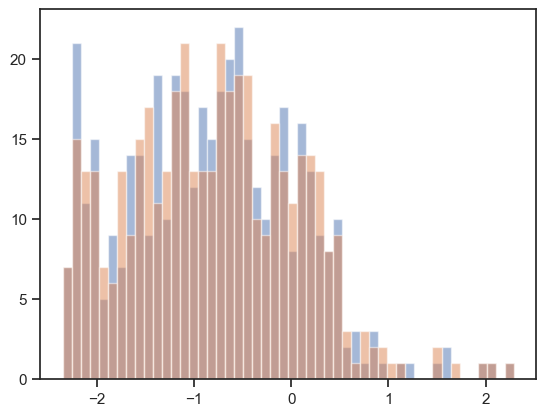

In [229]:
# Check pdfs of data and sample
plt.figure()
n0, bins0, patches0 = plt.hist(Yl[0].flatten(), bins=50, alpha=0.5)
n1, bins1, patches1 = plt.hist(sample.flatten(), bins=bins0, alpha=0.5)

In [513]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
from utils.areal_plots import seasonal_means

## Plot ideas

In [555]:
# Samples from the BCM model
F = m_rbcm.predict_f_samples(np.array(Xl).reshape(-1,3), 3, full_cov=False, full_output_cov=False)
samples_raw = F.numpy().reshape(3, -1).T
samples_tr = output_scaler.inverse_transform(samples_raw)
samples = inv_boxcox(samples_tr, lmbd)

# Create the data
df = pd.DataFrame(samples, columns=["historical", "RCP4.5", "RCP8.5"])
df["RCP4.5"] *= 1.5
df["RCP8.5"] *= 2
df_melt = df.melt(var_name="scenario", value_name="pr")

In [556]:
df

,historical,RCP4.5,RCP8.5
0,0.020423,0.024097,0.034788
1,0.058798,0.087890,0.087530
2,0.137524,0.221689,0.307450
3,0.225499,0.302540,0.522170
4,0.091168,0.161312,0.274558
...,...,...,...
43195,0.520495,0.896883,1.002474
43196,0.189225,0.276506,0.434761
43197,0.328102,0.610667,0.643202
43198,0.183251,0.341739,0.445874


In [553]:
df.to_csv("rbcm_single_rcm_samples.csv")


In [294]:
input_loc_arr = input_scaler.inverse_transform(np.array(Xl).reshape(-1, 3))

### Areal plots

#### Format/create the data

In [505]:
ypred, var = m_rbcm.predict_y(np.array(Xl).reshape(-1,3))
arr= np.stack((ypred.numpy().flatten(), var.numpy().flatten()), axis=1)
df_temp= pd.DataFrame(arr, columns=['pred0', 'var0'])

In [1]:
df_temp['y_pred'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp['pred0'].values, lmbd))
df_temp['95th_u'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp['pred0'].values + 1.96 * np.sqrt(df_temp['var0'].values), lmbd))
df_temp['95th_l'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp['pred0'].values - 1.96 * np.sqrt(df_temp['var0'].values), lmbd))
df_temp['CI'] = df_temp['95th_u'].fillna(0) - df_temp['95th_l'].fillna(0)
#df_temp[['time', 'lon', 'lat']] = input_loc_arr

NameError: name 'output_scaler' is not defined

In [511]:
df_temp[['y_pred', '95th_u', '95th_l', 'CI']] = df_temp[[
    'y_pred', '95th_u', '95th_l', 'CI']].fillna(0)

# To Data Array
df_temp.set_index(['time', 'lon', 'lat'], inplace=True)
ds = df_temp.to_xarray()


In [546]:
df_temp45 = df_temp.copy()
df_temp45[['y_pred', '95th_u', '95th_l', 'CI']] *=1.5
ds45 = df_temp45.to_xarray()

In [547]:
ds45.to_netcdf('rbcm_test_rcp45_output.nc')

####  Mean and 95th CI of the BCM model


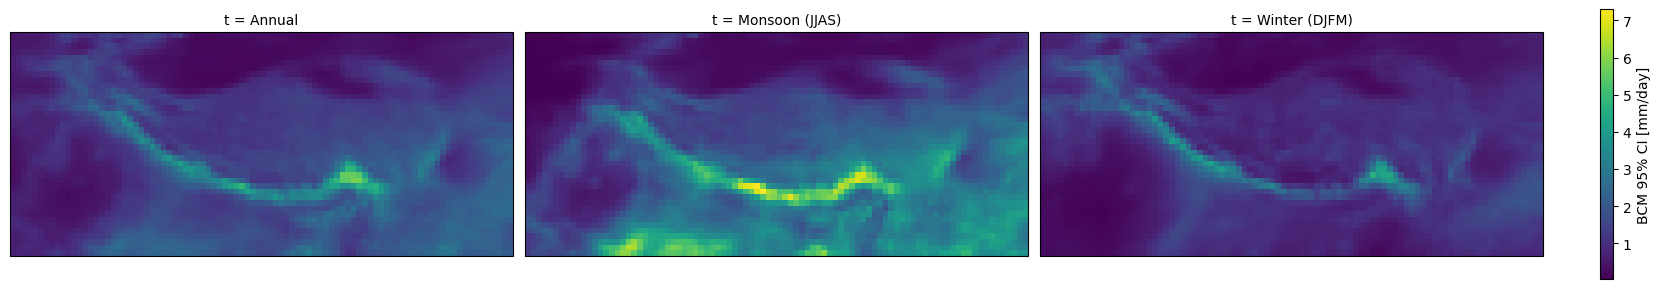

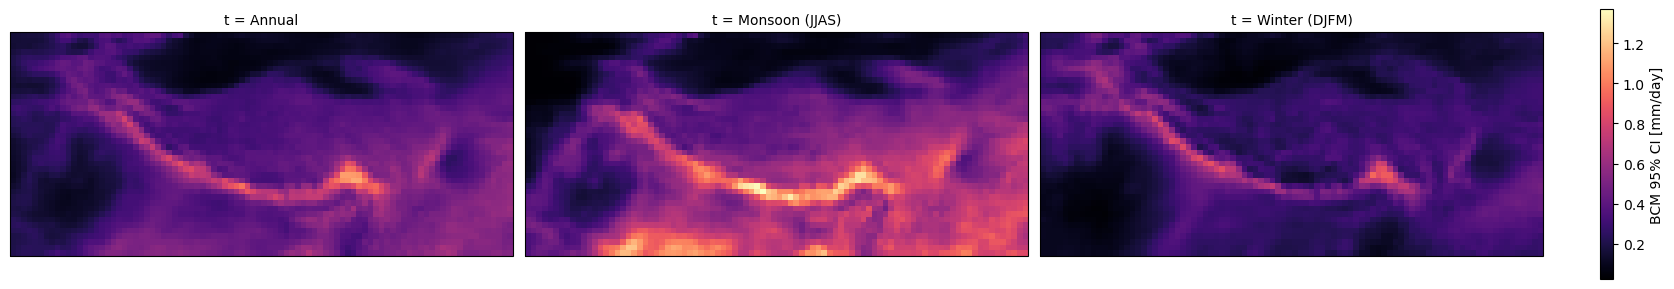

In [538]:
proj = ccrs.PlateCarree()
ds_avg_ypred = seasonal_means(ds.y_pred, 'y_pred')
ds_avg_CI = seasonal_means(ds.CI, 'CI')

ds_avg_ypred.plot(x="lon", y="lat", col="t", aspect=2, size=3, subplot_kws={"projection": proj}, cbar_kwargs={
    "label": "BCM 95% CI [mm/day]", 'pad': 0.03})

ds_avg_CI.plot(x="lon", y="lat", col="t",  aspect=2, cmap='magma', cbar_kwargs={
    "label": "BCM 95% CI [mm/day]", 'pad':0.03}, size=3, subplot_kws={"projection": proj})

plt.show()

#### Areas above 95th percentile

In [295]:
df[['time', 'lon', 'lat']] = input_loc_arr
df.fillna(0, inplace=True)

In [304]:
p95 = np.percentile(df.historical, 95)
p95 

8.592350958153752

In [377]:
ds = df.set_index(['time', 'lon', 'lat']).to_xarray()

In [428]:
ds['RCP4.5'].isel(time=0)


<xarray.DataArray 'RCP4.5' (lon: 90, lat: 40)>
array([[0.03579878, 0.01203121, 0.02809211, ..., 0.05060121, 0.0296838 ,
        0.0250561 ],
       [0.02307945, 0.03146879, 0.04343611, ..., 0.09165335, 0.03148628,
        0.07491477],
       [0.07838512, 0.04890009, 0.04286018, ..., 0.08402348, 0.016311  ,
        0.05194496],
       ...,
       [0.13288065, 0.19359774, 0.19266035, ..., 0.04380349, 0.07453367,
        0.32003872],
       [0.09674864, 0.14051734, 0.16485794, ..., 0.07129782, 0.15461894,
        0.41393229],
       [0.11779333, 0.10127964, 0.11449267, ..., 0.10257631, 0.28299609,
        0.38930517]])
Coordinates:
    time     float64 -2.827e+17
  * lon      (lon) float64 65.25 65.75 66.25 66.75 ... 108.2 108.8 109.2 109.8
  * lat      (lat) float64 22.25 22.75 23.25 23.75 ... 40.25 40.75 41.25 41.75

In [464]:
from matplotlib.patches import Patch


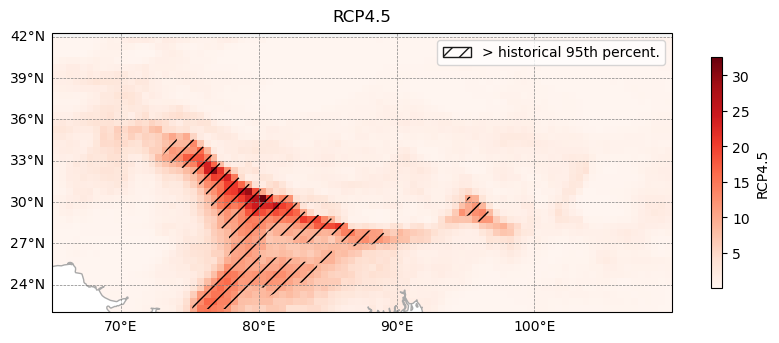

In [469]:

proj = ccrs.PlateCarree()

# Main plot
fig, ax1 = plt.subplots(subplot_kw={'projection': proj}, figsize=(10, 6))

# Map
land_50m = cf.NaturalEarthFeature("physical", "land", "50m", edgecolor="darkgrey",facecolor='whitesmoke',)
ocean_50m = cf.NaturalEarthFeature("physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

ax1.set_extent([65, 110, 22, 40])
ax1.add_feature(land_50m, zorder=1)
ds['RCP4.5'].isel(time=0)

#ax1.coastlines("50m", linewidth=0.4)

ds['RCP4.5'].isel(time=0).plot(x='lon', y='lat', cmap='Reds', transform=proj, 
                               add_colorbar=True, cbar_kwargs={'shrink': 0.5}, ax=ax1)

cs = ds.isel(time=0)['RCP4.5'].plot.contourf(x='lon', y='lat', hatches=['', '//'], levels=[p95, 100], 
                                             colors='none', add_colorbar=False,  ax=ax1, transform=ccrs.PlateCarree())

gl = ax1.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False

hdl = [Patch(facecolor='none', edgecolor='k', hatch='//', label='> historical 95th percent.')]
ax1.legend(handles = hdl)
ax1.add_feature(ocean_50m)
ax1.set_title('RCP4.5')
plt.show()

# Save figure
#plt.savefig('map_plot.pdf', dpi=300, bbox_inches='tight')


### Areas below 5th percentile

In [451]:
p5 = np.percentile(df.historical, 5)
p5

0.0012837931847299458

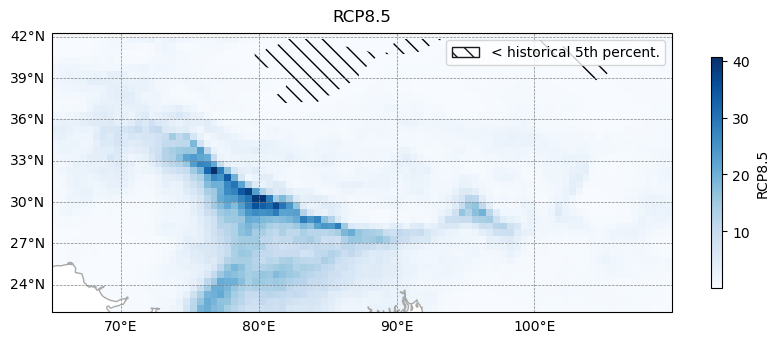

In [470]:
proj = ccrs.PlateCarree()

# Main plot
fig, ax1 = plt.subplots(subplot_kw={'projection': proj}, figsize=(10, 6))

# Map
land_50m = cf.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="darkgrey", facecolor='whitesmoke',)
ocean_50m = cf.NaturalEarthFeature(
    "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

ax1.set_extent([65, 110, 22, 40])
ax1.add_feature(land_50m, zorder=1)
ds['RCP4.5'].isel(time=0)

#ax1.coastlines("50m", linewidth=0.4)

ds['RCP8.5'].isel(time=0).plot(x='lon', y='lat', cmap='Blues', transform=proj,
                               add_colorbar=True, cbar_kwargs={'shrink': 0.5}, ax=ax1)

cs = ds.isel(time=0)['RCP8.5'].plot.contourf(x='lon', y='lat', hatches=['\\\\', ''], levels=[
    0, p5], colors='none', add_colorbar=False,  ax=ax1, transform=ccrs.PlateCarree())

gl = ax1.gridlines(draw_labels=True, linewidth=0.5,
                   linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False

hdl = [Patch(facecolor='none', edgecolor='k', hatch='\\\\',
             label='< historical 5th percent.')]

# Save and plot figure
ax1.legend(handles=hdl)
ax1.add_feature(ocean_50m)
ax1.set_title('RCP8.5')
plt.show()


### PDFs

How should I go about choosing threshold?

Then can calculate the increase in likelikhood of very high/low precipiation months etc (e.g. 3 time increase in the number of months with precip > 15mm/day)

Will do this analysis for the whole basin but are there some keys areas of interest I should look at more specifically?

#### Low threshold cumulative distribution function

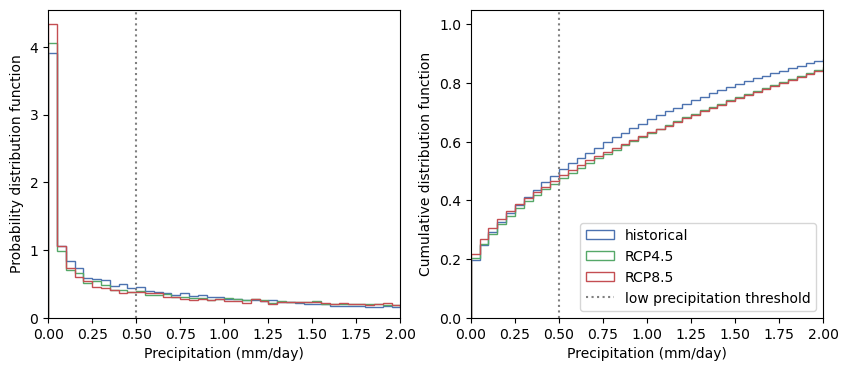

In [552]:
# sharey to have the same y axis limits, wspace=0 to make the axes connect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# x limits of the axes
xlim1 = (0, 2)

# calculate the histogram bin width such that it is equal for both axes
# we choose 50 bins per axis, you can change this value
bins1 = np.arange(xlim1[0], xlim1[1] + 1, np.diff(xlim1) / 40)

# plot the same data in both axes
ax1.hist(df['historical'], bins=bins1, edgecolor='b',
         histtype='step', label='historical', density=True, fill=False)
ax1.hist(df['RCP4.5'], bins=bins1, label='RCP4.5', edgecolor='g',
         histtype='step', density=True, fill=False)
ax1.hist(df['RCP8.5'], bins=bins1, label='RCP8.5', edgecolor='r',
         histtype='step', density=True, fill=False)

ax2.hist(df['historical'], bins=bins1, edgecolor='b', histtype='step', label='historical', cumulative=True, density=True, fill=False)
ax2.hist(df['RCP4.5'], bins=bins1, label='RCP4.5', edgecolor='g', histtype='step', cumulative=True, density=True, fill=False)
ax2.hist(df['RCP8.5'], bins=bins1, label='RCP8.5', edgecolor='r',  histtype='step', cumulative=True, density=True, fill=False)

# set the x limits
ax1.set_xlim(xlim1)
ax2.set_xlim(xlim1)

# add line to indicate the change in x scale
ax1.axvline(0.5, clip_on=False, color='gray', linestyle=':')
ax2.axvline(0.5, clip_on=False, color='gray', linestyle=':',
            label='low precipitation threshold')

leg = ax2.legend()
leg.get_frame().set_facecolor('none')

ax1.set_ylabel('Probability distribution function')
ax1.set_xlabel('Precipitation (mm/day)')

ax2.set_ylabel('Cumulative distribution function')
ax2.set_xlabel('Precipitation (mm/day)')
plt.show()

#### Combined PDFs

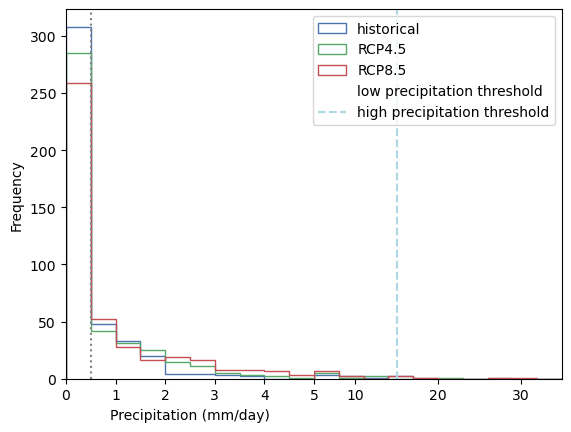

In [271]:
# sharey to have the same y axis limits, wspace=0 to make the axes connect
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'wspace': 0})

# x limits of the axes
xlim1 = (0, 5)
xlim2 = (5, 35)

# calculate the histogram bin width such that it is equal for both axes
# we choose 50 bins per axis, you can change this value
bins1 = np.arange(xlim1[0], xlim1[1] + 1, np.diff(xlim1) / 10)
bins2 = np.arange(xlim2[0], xlim2[1] + 1, np.diff(xlim2) / 10)

# plot the same data in both axes
ax1.hist(df['historical'], bins=bins1,
         label='historical', edgecolor='b',  fill=False, histtype='step',)
ax2.hist(df['historical'], bins=bins2,
         label='historical', edgecolor='b', fill=False, histtype='step',)

ax1.hist(df['RCP4.5'], bins=bins1, label='RCP4.5',
         edgecolor='g', fill=False, histtype='step')
ax2.hist(df['RCP4.5'], bins=bins2, label='RCP4.5', edgecolor='g', fill=False, histtype='step')

ax1.hist(df['RCP8.5'], bins=bins1, label='RCP8.5',
         fill=False, edgecolor='r', histtype='step')
ax2.hist(df['RCP8.5'], bins=bins2, label='RCP8.5', fill=False,  edgecolor='r', histtype='step')

# hide the spines and ticks
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax2.tick_params(axis='y', left=False)

# set the x limits
ax1.set_xlim(xlim1)
ax2.set_xlim(xlim2)

# add line to indicate the change in x scale
ax1.axvline(0.5, clip_on=False, color='gray', linestyle=':', label='low precipitation threshold')
ax2.axvline(-1, clip_on=False, color='gray', linestyle=':', alpha=0,
            label='low precipitation threshold')
ax2.axvline(15, clip_on=False, color='lightblue', linestyle='--', label='high precipitation threshold')

leg = ax2.legend()
leg.get_frame().set_facecolor('white')

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Precipitation (mm/day)')
plt.show()

#### Fancy seaborn plot

/Users/kenzatazi/miniconda3/envs/bcm4rcm/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/kenzatazi/miniconda3/envs/bcm4rcm/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/kenzatazi/miniconda3/envs/bcm4rcm/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/kenzatazi/miniconda3/envs/bcm4rcm/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


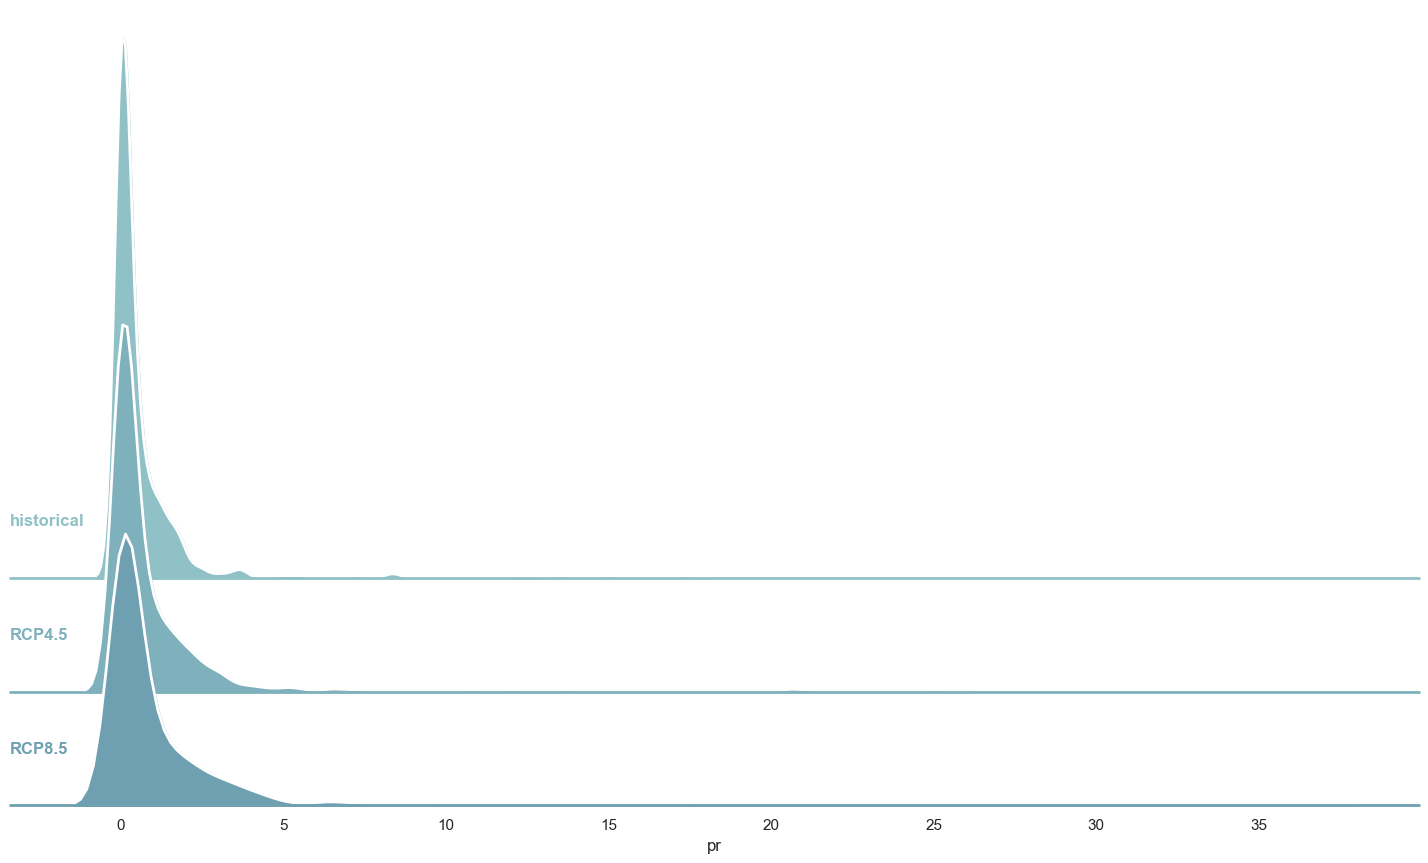

In [208]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="scenario", hue="scenario", aspect=5, height=3, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "pr",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "pr", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, 0.1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "pr")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.8)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

#### High treshold cumulative distribution function

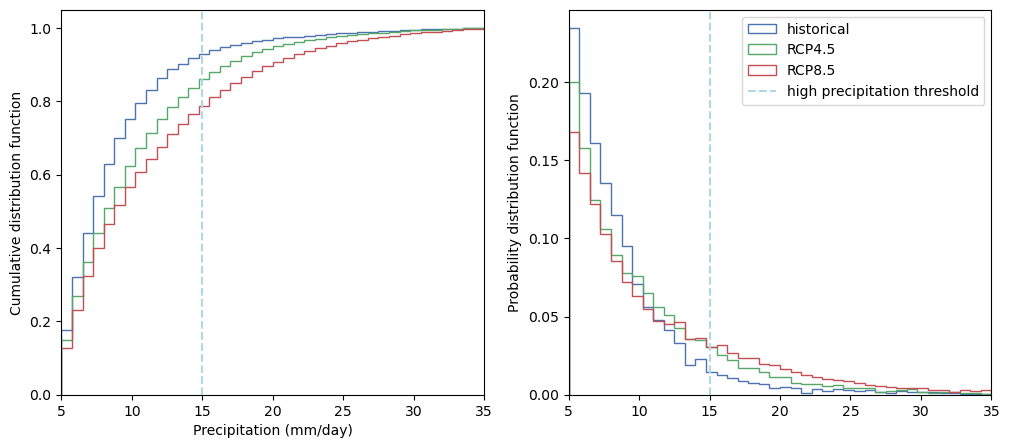

In [472]:
# sharey to have the same y axis limits, wspace=0 to make the axes connect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# x limits of the axes
xlim1 = (5, 35)

# calculate the histogram bin width such that it is equal for both axes
# we choose 50 bins per axis, you can change this value
bins1 = np.arange(xlim1[0], xlim1[1] + 1, np.diff(xlim1) / 40)

# plot the same data in both axes
ax1.hist(df['historical'], bins=bins1, edgecolor='b', density=True,
         histtype='step', label='historical', cumulative=True, fill=False)
ax1.hist(df['RCP4.5'], bins=bins1, label='RCP4.5', density=True, edgecolor='g',
         histtype='step', cumulative=True, fill=False)
ax1.hist(df['RCP8.5'], bins=bins1, label='RCP8.5', edgecolor='r', density=True,
         histtype='step', cumulative=True, fill=False)

# plot the same data in both axes
ax2.hist(df['historical'], bins=bins1, edgecolor='b', density=True,
         histtype='step', label='historical', fill=False)
ax2.hist(df['RCP4.5'], bins=bins1, label='RCP4.5', density=True, edgecolor='g',
         histtype='step', fill=False)
ax2.hist(df['RCP8.5'], bins=bins1, label='RCP8.5', edgecolor='r', density=True,
         histtype='step', fill=False)

# set the x limits
ax1.set_xlim(xlim1)
ax2.set_xlim(xlim1)

# add line to indicate the change in x scale
ax1.axvline(15, clip_on=False, color='lightblue',
            linestyle='--', label='high precipitation threshold')
ax2.axvline(15, clip_on=False, color='lightblue',
            linestyle='--', label='high precipitation threshold')

leg = ax2.legend()
leg.get_frame().set_facecolor('white')

ax1.set_ylabel('Cumulative distribution function')
ax2.set_ylabel('Probability distribution function')
ax1.set_xlabel('Precipitation (mm/day)')
plt.show()
